<a href="https://colab.research.google.com/github/jchen8000/GenerativeAI/blob/main/2_Pytorch_Basics_Math_Fundamentals/PyTorch_Basices_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. Pytorch Basics and Math Fundamentals (Part 3)

*   2.9. Neural Network
*   2.10	Bigram and N-gram Models
*   2.11	Greedy, Random Sampling and Beam





## 2.9	Neural Network

In [36]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time

In [37]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Read data
data = datasets.load_diabetes()
X, y = data.data, data.target

# Standardizing data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# train-test split for model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


torch.Size([353, 10]) torch.Size([353, 1])
torch.Size([89, 10]) torch.Size([89, 1])


In [38]:
class LinearRegression(nn.Module):

  def __init__(self, input_dim: int, output_dim: int) -> None:
    super(LinearRegression, self).__init__()
    self.fc1 = nn.Linear(input_dim, 32)
    self.fc2 = nn.Linear(32, 16)
    self.fc3 = nn.Linear(16, output_dim)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.fc3(x)
    return x

model = LinearRegression(X_train.shape[1], y_train.shape[1])
model.to(device)

total_parameter = sum(p.numel() for p in model.parameters())
print(f"Total Parameters: {total_parameter:,}")
print(model)

Total Parameters: 897
LinearRegression(
  (fc1): Linear(in_features=10, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)


In [39]:
learning_rate = 1e-3
epochs = 500  # number of epochs to run
batch_size = 64  # size of each batch

# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Hold the best model
best_mse = np.inf   # init to infinity
history = []

In [40]:
start_time = time.time()
for epoch in range(epochs):
    model.train()
    for i in range(0, len(X_train), batch_size):
        # take a batch
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        # forward pass
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if epoch % 10 == 0:
      print(f"Epoch {epoch}: Loss {mse:.8f}, time elapsed {(time.time()-start_time):.4f}s")
    if mse < best_mse:
        best_mse = mse

end_time = time.time()
print(f"Time spent: {(end_time-start_time):.8f}")

Epoch 0: Loss 30898.65234375, time elapsed 0.0276s
Epoch 10: Loss 30337.72460938, time elapsed 0.1730s
Epoch 20: Loss 27818.98046875, time elapsed 0.2953s
Epoch 30: Loss 20765.67382812, time elapsed 0.4740s
Epoch 40: Loss 11429.64648438, time elapsed 0.7742s
Epoch 50: Loss 6457.73876953, time elapsed 1.0733s
Epoch 60: Loss 4967.37792969, time elapsed 1.2243s
Epoch 70: Loss 4307.88085938, time elapsed 1.3727s
Epoch 80: Loss 3916.96875000, time elapsed 1.5100s
Epoch 90: Loss 3657.63696289, time elapsed 1.6476s
Epoch 100: Loss 3463.76904297, time elapsed 1.7749s
Epoch 110: Loss 3314.11035156, time elapsed 1.9053s
Epoch 120: Loss 3205.07519531, time elapsed 2.0736s
Epoch 130: Loss 3121.10961914, time elapsed 2.2060s
Epoch 140: Loss 3057.96142578, time elapsed 2.3337s
Epoch 150: Loss 3014.09936523, time elapsed 2.4461s
Epoch 160: Loss 2983.92797852, time elapsed 2.5802s
Epoch 170: Loss 2967.08325195, time elapsed 2.8195s
Epoch 180: Loss 2957.85595703, time elapsed 2.9380s
Epoch 190: Loss 29

MSE: 2952.77
RMSE: 54.34


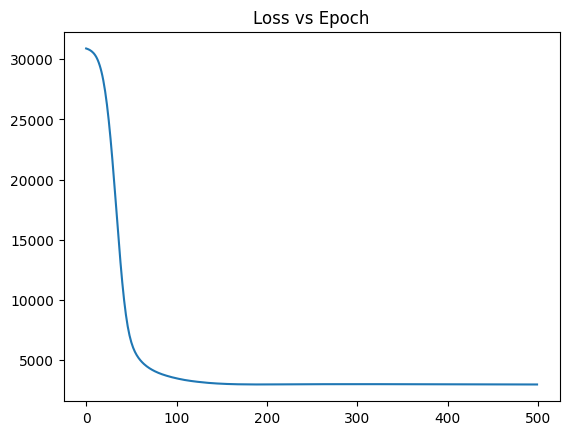

In [41]:
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.title('Loss vs Epoch')
plt.plot(history)
plt.savefig("logistic_regression_training_result.svg", format="svg", transparent=True, bbox_inches='tight')
plt.show()

## 2.10	Bigram and N-gram Models

In [42]:
!pip install 'portalocker>=2.0.0'

Loading and preparing text data

In [43]:
import re
from torchtext.datasets import IMDB

train_iter = IMDB(split='train')

In [44]:
def tokenize(label, line):
    line = re.sub('\s{2,}', ' ', line)              # convert multiple spaces to single space
    line = line.replace('"', '')                    # remove "
    line = re.sub('\<[^)]*\>', '', line)            # remove everything inside < >
    line = '<SOS> ' + line.replace('.', ' .')       # add a space to do and add a dot to the begining of the text
    return line.split()

words = []
for label, line in train_iter:
    words += tokenize(label, line)

Create a dictionary to record what words are following a given word

In [45]:
import random
bgrams = {}                       # dictionary to store word counts

# words = text.split()
for i in range(len(words)-2):
  w1 = words[i]                   # first word
  w2 = words[i+1]                 # second word
  if not w1 in bgrams:
    bgrams[w1] = {}
  if not w2 in bgrams[w1]:
    bgrams[w1][w2] = 1
  else:
    bgrams[w1][w2] += 1
print('Total words:', len(words))

Total words: 4602543


In [46]:
## Top 10 words after '<SOS>'
# dict(sorted(bgrams['<SOS>'].items(), key=lambda x:x[1], reverse=True)[:10])
# dict(sorted(bgrams['<SOS>'].items(), key=lambda x:-x[1])[:10])

Sorting and calculating probabilities

In [47]:
for w in bgrams:
  bgrams[w] = dict(sorted(bgrams[w].items(), key=lambda item: -item[1])[:10])
  total = sum(bgrams[w].values())
  bgrams[w] = dict([(k, bgrams[w][k]/total) for k in bgrams[w]])

Generating words and sentences

In [48]:
import random
random.seed(8888)
# this function takes a word and returns the next word.
def next_word(word):
  vars = bgrams[word]   #list of probable words for the given word
  # vars.keys() : list of possible words to choose from
  # vars.values() : list of probabilities for each possible words
  return random.choices(list(vars.keys()), weights=vars.values())[0]


def sentence(max_word=50):
  words = []
  w = '<SOS>'                 # first word is always '<SOS>'
  for i in range(max_word):         # limit max words to generate
    w = next_word(w)
    if w == '.':              # stop generating words by '.'
      break
    words.append(w)
  # return (' '.join(words) + '. ').capitalize()    # join all words to a sentence and add a dot at the end,
  return (' '.join(words) + '. ')

In [49]:
for i in range(20):
  print(sentence())

This is the movie was in their lines. 
I have to a good as a movie is a movie. 
This movie was very good. 
This is a lot about it would love this movie, and I had a few things and the film that the first time. 
I would like a little bit of a good job is a film for the other films of the film. 
This isn't a film is a great in the best. 
I have a movie. 
This is a very well. 
I was a lot of this film is a great deal. 
As a good film. 
The script. 
I don't even if you are not a good and a bit. 
This movie was the first half the film was a few of it was the movie was one of the film in this movie with the movie was a film. 
This is so much of the movie is a little too bad guy with some of the movie is a lot to watch it was in this film has a lot of his life. 
I have a lot of the worst of a lot of the same way the first time on the movie. 
This film has the film with a little more than it is a film that they are just about this is not as the film for his father is the movie. 
If you don't h

## 2.11	Greedy, Random Sampling and Beam

Greedy:

In [50]:
def greedy_search(probabilities):
    return torch.argmax(probabilities, dim=-1)

vocab = ["h", "e", "l", "o"]  # vocabulary
probabilities = torch.tensor([
    [0.4, 0.3, 0.1, 0.2],
    [0.1, 0.7, 0.2, 0.0],
    [0.1, 0.2, 0.5, 0.2],
    [0.1, 0.1, 0.6, 0.2],
    [0.2, 0.1, 0.1, 0.6]
])

output = greedy_search(probabilities)
print(output)
generated_word = "".join([vocab[i] for i in output])
print(generated_word)

tensor([0, 1, 2, 2, 3])
hello


Random Sampling:

In [51]:
import torch.nn.functional as F

def random_sampling(logits, top_k):
    top_k_probs, _ = torch.topk(logits, top_k, dim=-1)
    kth_highest_prob = top_k_probs[:, -1].unsqueeze(-1)
    mask = logits < kth_highest_prob
    probs = logits.masked_fill(mask, float('-inf'))
    probabilities = F.softmax(probs, dim=-1)
    output = torch.multinomial(probabilities, 1).squeeze(-1)
    return output

vocab = ["h", "e", "l", "o"]  # Vocabulary
logits = torch.tensor([
    [3.0, 1.0, 0.5, 0.1],
    [0.6, 3.5, 2.5, 0.2],
    [1.0, 0.2, 3.5, 1.5],
    [0.3, 2.5, 4.1, 0.4],
    [0.3, 1.0, 0.1, 4.4]
  ])

output = random_sampling(logits, top_k=2)
print(output)
generated_word = "".join([vocab[i] for i in output])
print(generated_word)

tensor([0, 1, 2, 2, 3])
hello


Beam:

In [52]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load pre-trained model and tokenizer
model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [53]:
input_text = "The quick brown fox"
input_ids = tokenizer.encode(input_text, return_tensors='pt')

attention_mask = torch.ones(input_ids.shape, dtype=torch.long)

# Generate sequences
outputs = model.generate(
  input_ids,
  max_length=50,
  num_beams=5,
  early_stopping=True,
  attention_mask=attention_mask,
  pad_token_id=tokenizer.eos_token_id
)

# Decode generated sequences
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

The quick brown foxes have been known to eat a variety of foods, including meat, fish, eggs, nuts, seeds, nuts, seeds, nuts, seeds, nuts, seeds, nuts, seeds, nuts, seeds, nuts, seeds,
